In [1]:
from model import *
from train_test_split import *
from predictionsGraph import *
from data_set import *
from torch.utils.data import DataLoader
from data_set import weighted_mse_loss

In [2]:
seq_len = 7 #the value has to be the same as in training
batch_size = 1 #has to be equal to 1 for testing
hidden_dim = 256
attention = True
target='PRAM'
nr_days = 2
nr_sim = 30
dropout=0.1
use_weights = False
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
#test_years = [2016,2017]
fold = 7

rj_test_years = {1:[2014,2015], 2:[2015,2016], 3:[2016,2017], 4:[2017,2018], 5:[2018,2019], 6:[2019,2020], 7:[2020,2021]}
test_years = rj_test_years[fold]
valid_years = [y-2 for y in test_years]

In [3]:
def calculateMean(targ='PRAM', locations=['NS'], train_years=[2015, 2016], data = 'real_for_all_NS_2000_2021.csv'):
    #targ = targ
    data = pd.read_csv(data)
    data = data[[targ, 'GOD', 'LOK']]
    train_dataset = data[data['GOD'].isin(train_years)]
    MEAN = train_dataset[targ].mean()
    return MEAN

def returnTensorToStartingValues(t, mean):
    return (torch.exp(t)-1)*mean

train_data, valid_data, test_data = load_data(f'sim-30-{target}-jump_weights-real_for_all_NS_2000_2021.csv', exclude_years=[g for g in range(2000, 2022) if g>test_years[1]], target=target, test_years = test_years, valid_years = valid_years, use_weights = use_weights, nr_sim=nr_sim)

realValues = []
w = []
for dan in range(nr_days):
    realValues.append([])
    w.append([])
predictedValuesTotal = []

for i in range(nr_sim):
    train_dataset = Dataset(train_data, seq_len, nr_days, f'{i}-sim')
    valid_dataset = Dataset(valid_data, seq_len, nr_days, target)
    test_dataset = Dataset(test_data, seq_len, nr_days, target)

    input_dim = train_dataset[0][0].shape[1]
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=1)

    model = Net(input_dim,  hidden_dim = hidden_dim, nr_days = nr_days, seq_len = seq_len, attention = attention, device = device, dropout=dropout)
    path_to_model = f'models/{target}/MMSD/{i}-sim_batch_size_32-seq_len_{seq_len}-nr_days_{nr_days}-lr_0.001-hidd_dim_{hidden_dim}-att_{attention}-use_weights_{use_weights}-dropout_{dropout}-best.weights'
    
    model.load_state_dict(torch.load(path_to_model))
    model.eval()
    MEAN = calculateMean(targ=f'{i}-sim', locations=['NS'], train_years=[g for g in range(2000,2022) if g < valid_years[0]], data = f'sim-30-{target}-jump_weights-real_for_all_NS_2000_2021.csv' )    
    predictedValues = []
    for dan in range(nr_days):
        predictedValues.append([])
    model.to(device)
    
    for (inputs, meteo, labels, weights) in test_loader:
        inputs, meteo, labels, weights = inputs.to(device), meteo.to(device), labels.to(device), weights.to(device)
        output = model(inputs, meteo)#, h)
        for dan in range(nr_days):
            predictedValues[dan].append(output[0][dan].item())
            if i==nr_sim-1:
                realValues[dan].append(labels[0][dan].item()) #we only need to calculate real values once, not for all nr_sim models (real values are always the same)
                w[dan].append(weights[0][dan].item())

    for dan in range(nr_days):
        predictedValues[dan]= torch.FloatTensor(predictedValues[dan])
        predictedValues[dan] = returnTensorToStartingValues(predictedValues[dan],MEAN)
            
    predictedValuesTotal.append(torch.stack(predictedValues))
    

MEAN_forRealValues = calculateMean(targ=target, locations=['NS'], train_years=[g for g in range(2000,2022) if g < valid_years[0]], data=f'sim-30-{target}-jump_weights-real_for_all_NS_2000_2021.csv')
for dan in range(nr_days):
    realValues[dan] = torch.FloatTensor(realValues[dan])
    realValues[dan] = returnTensorToStartingValues(realValues[dan],MEAN_forRealValues)
    w[dan] = torch.FloatTensor(w[dan])
#print(predictedValuesTotal)
suma = torch.zeros_like(predictedValuesTotal[0])
for el in predictedValuesTotal:
    suma = suma + el
predictedValues = suma/nr_sim
#predictedValues[1]

In [4]:
naivePrediction = []
naivePrediction.append(realValues[0][0].item()) #the first day is equal to the real value, all the rest days have values copied from previous day
for i in range(1,len(realValues[0])):
    naivePrediction.append(realValues[0][i-1].item())
naivePrediction = torch.FloatTensor(naivePrediction)

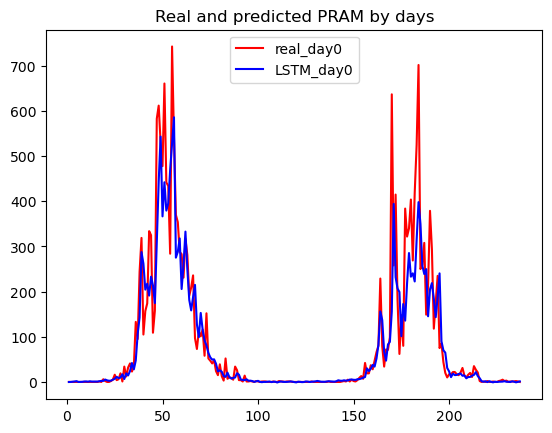

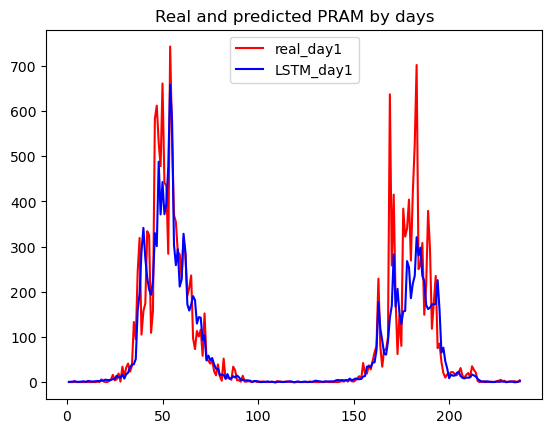

DAY 0  loss LSTM: tensor(68.4356) loss naive model: tensor(90.2728)
DAY 1  loss LSTM: tensor(73.6675) loss naive model: tensor(105.0444)


In [5]:
for dan in range(nr_days):
    predictionsGraph([realValues[dan], predictedValues[dan]], ['real_day'+str(dan), 'LSTM_day'+str(dan)],target)

loss_fn = nn.MSELoss(reduction='mean')
wloss_fn = weighted_mse_loss(reduction='mean')
for dan in range(nr_days):
    loss1 = np.sqrt(loss_fn(realValues[dan], predictedValues[dan]))
    loss2 = np.sqrt(loss_fn(realValues[dan], naivePrediction))
    print('DAY',dan,' loss LSTM:',loss1,'loss naive model:', loss2)